# **Formula 1 Data Analysis (1950-2024)**

### **INTRODUCTION**
- **Project Overview:** The Formula 1 Data Analysis (1950-2024) project explores historical performance data from Formula 1 racing to identify trends in driver and team performance, race outcomes, and the impact of different circuits. Using dataset from Kaggle, including race results, driver standings, lap times, and circuit data, this project aims to uncover insights into the evolution of Formula 1. The analysis is conducted with Python for data processing, SQL for querying, and a Power BI dashboard for visualizations.

- **Context and Relevance:** Formula 1 is a dynamic sport where performance is influenced by multiple factors, such as driver skill, team strategies, and technological advancements. This project helps analyze:
    - Driver and Team Performance: How drivers and teams have evolved over time.
    - Driver and Constructor Analysis: A deeper look at how individual driver performances and constructor results have changed over the years, identifying patterns of dominance and rivalry.
    - Circuit Characteristics: How different types of circuits (e.g., street vs. traditional) influence race strategies and outcomes.


### **Data Collection and Sources**
- **kaggle Dataset:** This project uses a comprehensive [Formula 1 dataset](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020/data) from Kaggle, which includes multiple CSV files such as:

    - Circuits: Information about different race circuits (e.g., names, locations, and lengths).
    - Driver Standings: Historical data on driver rankings by season and race.
    - Constructor Results: Performance of constructors (teams) over the years.
    - Lap Times: Detailed timing data for each driver in each race.
    - Pit Stops: Information on pit stop timings and strategies during races.
    - Races: Metadata about individual races, including locations, dates, and results.

- **Data Availability:** The dataset spans from 1950 to 2024, covering over seven decades of Formula 1 history. This range enables analysis of long-term trends, including the evolution of teams, drivers, circuits, and race outcomes.

- **Data Format and Importing:** The datasets are provided in CSV format. They were imported into Python using libraries like pandas for processing and exploration. Each dataset was subsequently uploaded into an SQLite database using SQLAlchemy and the to_sql() function, ensuring efficient data storage and enabling SQL-based querying for deeper insights.



In [1]:
#Importing libarires required to perform cleaning operations and data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
import sqlite3 

In [2]:
#importing csv file to a dataframe
circuits = pd.read_csv(r'dataset files\circuits.csv')
constructor_results = pd.read_csv(r'dataset files\constructor_results.csv')
constructor_standings = pd.read_csv(r'dataset files\constructor_standings.csv')
constructors = pd.read_csv(r'dataset files\constructors.csv')
driver_standings = pd.read_csv(r'dataset files\driver_standings.csv')
drivers = pd.read_csv(r'dataset files\drivers.csv')
lap_times = pd.read_csv(r'dataset files\lap_times.csv')
pit_stops = pd.read_csv(r'dataset files\pit_stops.csv')
qualifying = pd.read_csv(r'dataset files\qualifying.csv')
races = pd.read_csv(r'dataset files\races.csv')
results = pd.read_csv(r'dataset files\results.csv')
seasons = pd.read_csv(r'dataset files\seasons.csv')
sprint_results = pd.read_csv(r'dataset files\sprint_results.csv')
status = pd.read_csv(r'dataset files\status.csv')

### **Data Exploration and Preprocessing**

- **Data Cleaning:** Addressed missing values, standardized data types (e.g., dates, times), and removed duplicates for consistency.

- **Data Transformation:** Merged datasets to create comprehensive views, such as combining race results with driver standings and circuits.
Added calculated fields like win percentages, average lap times, and points per season to enhance analysis.

- **Database Integration:** Imported cleaned datasets into an SQLite database using SQLAlchemy and to_sql().
Created tables for key datasets like drivers, constructors, circuits, and races. Relationships between datasets were managed through SQL joins during queries.

In [3]:
#dropping unnecessary columns from the dataframes
circuits.drop('url', axis=1, inplace= True)
constructors.drop('url', axis=1, inplace= True)
drivers.drop('url', axis=1, inplace= True)
seasons.drop('url', axis=1, inplace= True)
constructor_results.drop('status', axis=1, inplace=True)
constructor_standings.drop('positionText', axis=1, inplace= True)
races.drop(columns= ['url','fp1_date','fp1_time','fp2_date','fp2_time','fp3_date',\
                     'fp3_time','quali_date','quali_time','sprint_date','sprint_time'], axis=1, inplace=True)

In [4]:
#filling NA values for q2 and q3 NULL values
qualifying['q2'] = qualifying['q2'].fillna('NA')
qualifying['q3'] = qualifying['q3'].fillna('NA')

In [5]:
#fucntion to convert time (in format min:sec:msec) to milliseconds
def time_to_milliseconds(time_str):
    # Handle invalid or missing values
    if time_str == '\\N' or not time_str:
        return None  # or return 0 depending on how you want to handle missing data

    # Split the time string by ':'
    time_parts = time_str.split(':')

    # Handle cases where there are 2 parts (minutes and seconds) or 1 part (seconds only)
    if len(time_parts) == 2:
        minutes, seconds = time_parts
        milliseconds = 0
    elif len(time_parts) == 1:
        minutes = 0
        seconds = time_parts[0]
        milliseconds = 0
    else:
        minutes, seconds, milliseconds = time_parts
    
    # If seconds have a decimal, split seconds into whole and fractional parts
    if '.' in seconds:
        seconds, milliseconds = seconds.split('.')
        milliseconds = milliseconds.ljust(3, '0')  # Ensure milliseconds are 3 digits
    
    # Convert everything to integer values
    try:
        minutes = int(minutes)
        seconds = int(seconds)
        milliseconds = int(milliseconds)
    except ValueError:
        return None  # In case the value cannot be converted to an integer, return None or handle the error

    # Convert the time to milliseconds
    return (minutes * 60 * 1000) + (seconds * 1000) + milliseconds
results['fastestLap_time_ms'] = results['fastestLapTime'].apply(time_to_milliseconds)

In [6]:
l = ['number', 'fastestLapSpeed', 'milliseconds', 'rank', 'fastestLap_time_ms']
for i in l:
    results[i] = pd.to_numeric(results[i], errors= 'coerce')

In [7]:
#Handling missing values
results['fastestLapSpeed'] = results['fastestLapSpeed'].replace('\\N',results['fastestLapSpeed'].mean())
results['fastestLap_time_ms'] = results['fastestLap_time_ms'].replace('\\N', results['fastestLap_time_ms'].mean())

In [8]:
fastestLapSpeed_mean = results['fastestLapSpeed'].mean()
fastestlaptime_mean = results['fastestLap_time_ms'].mean()

In [9]:
results['fastestLapSpeed'] = results['fastestLapSpeed'].fillna(fastestLapSpeed_mean)
results['fastestLap_time_ms'] = results['fastestLap_time_ms'].fillna(fastestlaptime_mean)

In [10]:
results.rename(columns= {'milliseconds':'Lap_time_ms'}, inplace= True)

In [11]:
#changing datatype for dob column in drivers and date column in races
drivers['dob']= pd.to_datetime(drivers['dob'])
races['date'] = pd.to_datetime(races['date'])

In [12]:
#Concatenating forname and surname column from drivers DF
drivers['Name'] = drivers['forename'] +" "+ drivers['surname']

In [13]:
#Dropping the forename and surname column
drivers.drop(columns= ['forename', 'surname'], axis=1, inplace= True)

In [14]:
#Handling NULL values for fastetsLapTime column
results = results[results['fastestLapTime'].notnull()]
results['fastestLapTime'] = results['fastestLapTime'].fillna(0)

In [15]:
results.dtypes

resultId                int64
raceId                  int64
driverId                int64
constructorId           int64
number                float64
grid                    int64
position               object
positionText           object
positionOrder           int64
points                float64
laps                    int64
time                   object
Lap_time_ms           float64
fastestLap             object
rank                  float64
fastestLapTime         object
fastestLapSpeed       float64
statusId                int64
fastestLap_time_ms    float64
dtype: object

In [16]:
#printing all the dataframes imported to csv
display(circuits.head())
display(constructor_results.head())
display(constructor_standings.head())
display(constructors.head())
display(driver_standings.head())
display(drivers.head())
display(lap_times.head())
display(pit_stops.head())
display(qualifying.head())
display(races.head())
display(results.head())
display(seasons.head())
display(sprint_results.head())
display(status.head())

,circuitId,circuitRef,name,location,country,lat,lng,alt
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130


,constructorResultsId,raceId,constructorId,points
0,1,18,1,14.0
1,2,18,2,8.0
2,3,18,3,9.0
3,4,18,4,5.0
4,5,18,5,2.0


,constructorStandingsId,raceId,constructorId,points,position,wins
0,1,18,1,14.0,1,1
1,2,18,2,8.0,3,0
2,3,18,3,9.0,2,0
3,4,18,4,5.0,4,0
4,5,18,5,2.0,5,0


,constructorId,constructorRef,name,nationality
0,1,mclaren,McLaren,British
1,2,bmw_sauber,BMW Sauber,German
2,3,williams,Williams,British
3,4,renault,Renault,French
4,5,toro_rosso,Toro Rosso,Italian


,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


,driverId,driverRef,number,code,dob,nationality,Name
0,1,hamilton,44,HAM,1985-01-07,British,Lewis Hamilton
1,2,heidfeld,\N,HEI,1977-05-10,German,Nick Heidfeld
2,3,rosberg,6,ROS,1985-06-27,German,Nico Rosberg
3,4,alonso,14,ALO,1981-07-29,Spanish,Fernando Alonso
4,5,kovalainen,\N,KOV,1981-10-19,Finnish,Heikki Kovalainen


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236


,raceId,year,round,circuitId,name,date,time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,Lap_time_ms,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,fastestLap_time_ms
0,1,18,1,1,22.0,1,1,1,1,10.0,58,1:34:50.616,5690616.0,39,2.0,1:27.452,218.300,1,87452.0
1,2,18,2,2,3.0,5,2,2,2,8.0,58,+5.478,5696094.0,41,3.0,1:27.739,217.586,1,87739.0
2,3,18,3,3,7.0,7,3,3,3,6.0,58,+8.163,5698779.0,41,5.0,1:28.090,216.719,1,88090.0
3,4,18,4,4,5.0,11,4,4,4,5.0,58,+17.181,5707797.0,58,7.0,1:28.603,215.464,1,88603.0
4,5,18,5,1,23.0,3,5,5,5,4.0,58,+18.014,5708630.0,43,1.0,1:27.418,218.385,1,87418.0


,year
0,2009
1,2008
2,2007
3,2006
4,2005


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,fastestLapTime,statusId
0,1,1061,830,9,33,2,1,1,1,3,17,25:38.426,1538426,14,1:30.013,1
1,2,1061,1,131,44,1,2,2,2,2,17,+1.430,1539856,17,1:29.937,1
2,3,1061,822,131,77,3,3,3,3,1,17,+7.502,1545928,17,1:29.958,1
3,4,1061,844,6,16,4,4,4,4,0,17,+11.278,1549704,16,1:30.163,1
4,5,1061,846,1,4,6,5,5,5,0,17,+24.111,1562537,16,1:30.566,1


,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [17]:
#Importing SQLAlchemy to integrate into the project
from sqlalchemy import MetaData, create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy import text
metadata =MetaData()

In [18]:
# Define the SQLite database
engine = create_engine('sqlite:///f1_data.db')
Base = declarative_base()

In [19]:
# pushing dataframe into sql tables
circuits.to_sql('circuits', engine, index= False, if_exists= 'replace')
drivers.to_sql('drivers', engine, index= False, if_exists= 'replace')
driver_standings.to_sql('driver_standings', engine, index= False, if_exists= 'replace')
constructor_results.to_sql('constructor_results', engine, index= False, if_exists= 'replace')
constructor_standings.to_sql('constructor_standings', engine, index= False, if_exists= 'replace')
constructors.to_sql('constructors', engine, index= False, if_exists= 'replace')
races.to_sql('races', engine, index= False, if_exists= 'replace')
lap_times.to_sql('lap_times', engine, index= False, if_exists= 'replace')
pit_stops.to_sql('pit_stops', engine, index= False, if_exists= 'replace')
qualifying.to_sql('qualifying', engine, index = False, if_exists= 'replace')
status.to_sql('status', engine, index = False, if_exists= 'replace')
results.to_sql('results', engine, index = False, if_exists= 'replace')
sprint_results.to_sql('sprint_results', engine, index = False, if_exists= 'replace')
seasons.to_sql('seasons', engine, index = False, if_exists= 'replace')

75

#### **Circuits Distribution and Occurence**
- Formula One races have been held across the globe, featuring a variety of circuits over the years. Some tracks are iconic, like the Monaco Circuit, which has been part of F1 since its inception in 1950, while others have been added and removed from the calendar.
- **Objective:**
    - Identify all circuits where a Grand Prix has been held.
    - Calculate the frequency of each circuit's appearance in the F1 calendar.
    - Visualize the distribution and occurrence of these circuits on a world map for better geographical understanding.
- This analysis highlights trends in the choice of circuits, including those that have been historically significant and those that are part of newer additions.

In [20]:
#renaming column in races table
with engine.connect() as connection:
    connection.execute(text("""ALTER TABLE races
                               RENAME COLUMN name TO Grand_Prix
                            """))

In [21]:
#query to find distinct circuits name and grand prix name and returing it into Circuit_df dataframe.
query = """
        SELECT DISTINCT circuits.name, circuits.country, 
        FIRST_VALUE(races.Grand_Prix) OVER (PARTITION BY circuits.circuitId ORDER BY races.year) AS grand_prix, 
        circuits.lat, circuits.lng, COUNT(races.year) as occurence
        FROM circuits
        JOIN races ON circuits.circuitId = races.circuitId
        GROUP BY circuits.name, circuits.country
        """
Circuit_df = pd.read_sql(query, engine)

In [22]:
#sorting the dataframe by occurence column in descending order
Circuit_df.sort_values(by= 'occurence', ascending= False, inplace= True)
Circuit_df

,name,country,grand_prix,lat,lng,occurence
13,Autodromo Nazionale di Monza,Italy,Italian Grand Prix,45.6156,9.28111,74
5,Circuit de Monaco,Monaco,Monaco Grand Prix,43.7347,7.42056,70
8,Silverstone Circuit,UK,British Grand Prix,52.0786,-1.01694,59
12,Circuit de Spa-Francorchamps,Belgium,Belgian Grand Prix,50.4372,5.97139,57
6,Circuit Gilles Villeneuve,Canada,Canadian Grand Prix,45.5000,-73.52280,43
...,...,...,...,...,...,...
55,Zeltweg,Austria,Austrian Grand Prix,47.2039,14.74780,1
62,Ain Diab,Morocco,Moroccan Grand Prix,33.5786,-7.68750,1
61,Sebring International Raceway,USA,United States Grand Prix,27.4547,-81.34830,1
63,Pescara Circuit,Italy,Pescara Grand Prix,42.4750,14.15080,1


In [23]:
#utilizing the scatte_geo to plot the circuit_df in geographical manner
fig = px.scatter_geo(data_frame= Circuit_df, lat= 'lat', lon= 'lng', hover_name= 'name',
                     hover_data= {'occurence': True, 'grand_prix': True},
                     projection= 'natural earth',
                     color= 'country')
fig.update_traces(marker = dict(line= dict(width= 0.5, color= 'black')),
                  hovertemplate= "<b>%{hovertext}<b><br>"+
                                 "<b>%{customdata[1]}<b><br>"+
                                 "occurence:  %{customdata[0]:,.0f}<br>"
                    )
fig.show()

#### **Driver Performance**
*If you no longer go for a gap that exists, you're no longer a racing driver - Ayrton Senna*

- Formula One boasts a rich history of extraordinary drivers, from legends like Alain Prost, Niki Lauda, and Ayrton Senna to modern champions such as Michael Schumacher, Sebastian Vettel, Fernando Alonso, Lewis Hamilton, and Max Verstappen.
- A Grand Prix winner is crowned when a driver finishes the race in first place. Over the decades, many drivers have achieved remarkable success, setting historic records with their victories.
- **Objective:**
    - Identify the top 10 drivers with the most Grand Prix wins by calculating how many times each driver has finished in position = 1.
    - Represent this data visually using a bar plot for clear comparison.

In [24]:
#driver performance 
query = """
        SELECT drivers.Name, COUNT(results.position) AS wins
        FROM drivers
        JOIN results ON drivers.driverId = results.driverId
        WHERE results.position = 1
        GROUP BY drivers.driverId
        ORDER BY wins DESC
        """
driver_performance = pd.read_sql(query, engine)
driver_performance

,Name,wins
0,Lewis Hamilton,104
1,Michael Schumacher,91
2,Max Verstappen,61
3,Sebastian Vettel,53
4,Alain Prost,51
...,...,...
109,Jean Alesi,1
110,Olivier Panis,1
111,Jarno Trulli,1
112,Robert Kubica,1


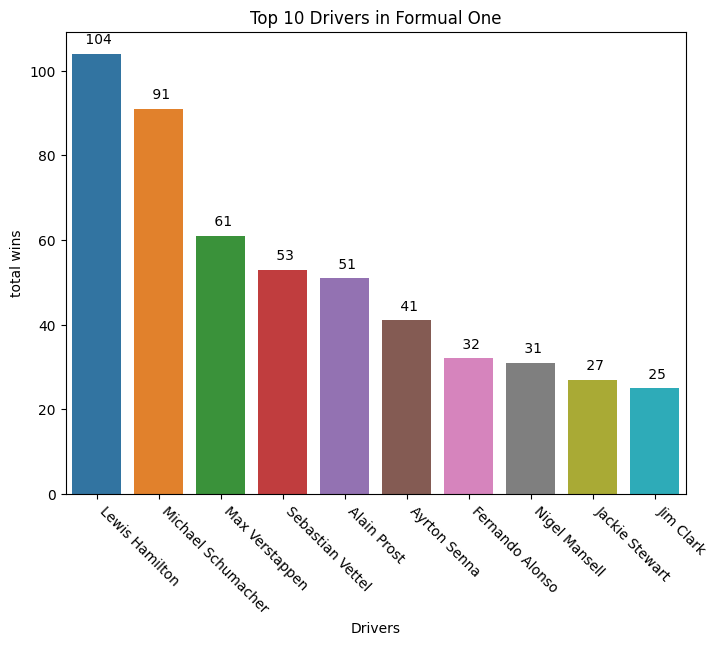

In [25]:
#Plotting the data on seaborn bar plot
plt.figure(figsize= (8,6))
ax = sns.barplot(data= driver_performance.head(10), x= 'Name',y= 'wins', hue= 'Name')
plt.title('Top 10 Drivers in Formual One')
plt.ylabel('total wins')
plt.xlabel('Drivers')
plt.xticks(rotation = -45, ha= 'left',va= 'top')
for p in ax.patches:
    ax.annotate(f'{p.get_height(): .0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='bottom', 
                xytext=(0, 5),  # Offset to move text 5 points above the bar
                textcoords='offset points')
plt.show()

### Driver Championship
*The championship isn’t won in a single race. It’s a journey of consistency, adaptability, and seizing every opportunity<br>- Lewis Hamilton (7-time F1 World Champion)*
- In Formula One, every driver aspires to achieve the ultimate accolade: the Drivers' Championship. However, only a select few succeed in turning this dream into reality.
- The Drivers' Championship is awarded at the end of each season to the driver with the most points accumulated across all Grand Prix events. This honor symbolizes not only individual excellence but also resilience, adaptability, and consistency over the course of a demanding season.
- **Objective:** Using historical F1 data from 1950 to 2023, we identified all Drivers' Championship winners and calculated the total number of titles won by each driver. The results were visualized in a bar graph, showcasing the legends of the sport and their dominance across different eras.

In [26]:
query = """    
SELECT year, name 
FROM driver_standings AS ds
JOIN(
SELECT year, raceId 
FROM races
GROUP BY year
HAVING MAX(round)
)AS max_race
ON max_race.raceId = ds.raceId
JOIN drivers AS d
ON d.driverId = ds.driverId
WHERE position = 1
ORDER BY year DESC
"""
driver_championship_df = pd.read_sql(query, engine)
driver_championship_df.head()

,year,Name
0,2023,Max Verstappen
1,2022,Max Verstappen
2,2021,Max Verstappen
3,2020,Lewis Hamilton
4,2019,Lewis Hamilton


In [27]:
driver_championship_df = driver_championship_df.groupby(by= 'Name').size().reset_index(name= 'Driver Championship Wins').sort_values(by= 'Driver Championship Wins', ascending= False)

In [28]:
driver_championship_df.reset_index(drop= True, inplace=True)

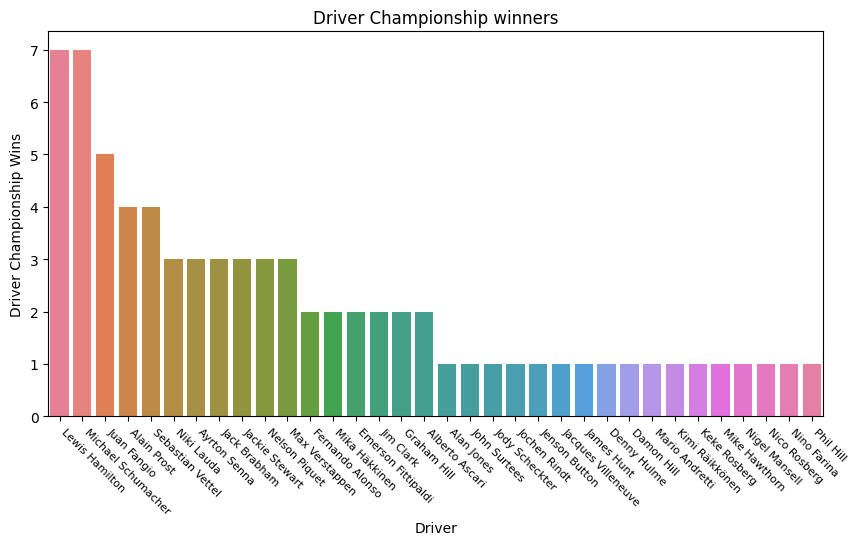

In [29]:
plt.figure(figsize = (10,5))
sns.barplot(data= driver_championship_df, x= 'Name', y= 'Driver Championship Wins', hue= 'Name')
plt.xlabel('Driver')
plt.xticks(rotation = -45, ha= 'left', va= 'top', fontsize= 8)
plt.title('Driver Championship winners')
plt.show()

#### **Total Constructor Wins**
*Formula 1 is not just about the driver; it’s about every single person at the factory. Without them, there’s no car<br> - Toto Wolf* *(Mercedes-AMG Team Principal.)*

- Formula One has witnessed numerous legendary constructors (teams) throughout its history. Among them, Ferrari stands out as the only team to have participated in every F1 season since 1950.
- In Formula One, the most successful constructor of a Grand Prix is determined by the team accumulating the most points from that race. Over the years, several teams have achieved remarkable success, leaving their mark on the sport's history.
- **Objective**:
    -Calculate the total number of constructor wins for each team and visualize their achievements to understand the dominance of various constructors across different eras.

In [30]:
#query to find out total constructor wins 
query = """
        SELECT constructors.name, COUNT(constructor_standings.position) as wins 
        FROM constructors
        JOIN constructor_standings ON constructors.constructorId = constructor_standings.constructorId
        JOIN races ON races.raceId = constructor_standings.raceId
        WHERE (constructor_standings.position) = 1
        GROUP BY constructors.constructorId
        ORDER BY wins DESC
"""
constructor_performance = pd.read_sql(query, engine)
constructor_performance.head()

,name,wins
0,Ferrari,234
1,McLaren,165
2,Mercedes,145
3,Red Bull,120
4,Williams,114


In [31]:
#plotting thr data on a plotly bar plot
g = px.bar(data_frame= constructor_performance, 
           x= 'name', 
           y= 'wins',
           color= 'name',
           title= 'Total Constructor Wins',
           hover_name= 'name',
           hover_data= {'name': True, 'wins': True})
g.update_layout(
    xaxis_title = 'Constructors',
    yaxis_title = 'Total Wins',
    showlegend = False,
    title = {'text': "Total Constructor Wins", 'x': 0.5, 'xanchor':'center', 'yanchor':'top'}
)
g.update_traces(
    hovertemplate= "<b>Constructor Name: %{x}</b><br>" +
                    "<b>Constructor Wins: %{y}</b><br>"
)
g.show()

#### **Constructor Championship Wins**
***Winning a race feels great. Winning a championship is better. Winning as a constructor is the pinnacle<br> - Niki Lauda*** *(F1 champion and team executive)*

- Winning the Constructor Championship is a monumental achievement for any Formula One team. It signifies not only dominance on the track but also the pinnacle of engineering and teamwork throughout an entire season.
- Each year, at the end of the F1 season, a single team is crowned the Constructor Champion, determined by the combined points of both drivers across all races in the calendar. This honor reflects a season-long consistency and superiority in both performance and strategy.
- **Objective:**
    - Retrieve the list of Constructor Championship winners for every season from 1950 to 2023, calculate the total championships won by each constructor, and visualize the data using a Plotly bar plot for better interpretation.

In [32]:
query= """
SELECT year, name 
FROM constructor_standings AS cs
JOIN(
SELECT year, raceId 
FROM races
GROUP BY year
HAVING MAX(round)
)AS max_race
ON max_race.raceId = cs.raceId
JOIN constructors AS c
ON c.constructorId = cs.constructorId
WHERE position = 1
ORDER BY year DESC
"""
res = pd.read_sql(query, engine)
res.head()

,year,name
0,2023,Red Bull
1,2022,Red Bull
2,2021,Mercedes
3,2020,Mercedes
4,2019,Mercedes


In [33]:
Constructor_champions = res.groupby(by= 'name').size().reset_index(name = 'Constructor Wins')

In [34]:
Constructor_champions.sort_values('Constructor Wins', ascending= False, inplace= True)
Constructor_champions.reset_index(drop=True, inplace= True)
Constructor_champions.head()

,name,Constructor Wins
0,Ferrari,16
1,Williams,9
2,McLaren,8
3,Mercedes,8
4,Red Bull,6


In [35]:
fig = px.bar(data_frame=Constructor_champions, 
                   x='name', 
                   y='Constructor Wins', 
                   title='Constructor Champions', 
                   color='name', 
                   hover_name='name', 
                   hover_data={'name': True, 'Constructor Wins': True})  # Proper hover data

# Update layout for axis titles and remove legend
fig.update_layout(
    xaxis_title='Constructors', 
    yaxis_title='Total Constructor Wins', 
    showlegend=False,
    title={'text': 'Constructor Champions', 'x': 0.5, 'yanchor': 'top', 'xanchor': 'center'}
)

# Update hover template to customize hover text
fig.update_traces(
    hovertemplate= 
                  "<b>Constructor Name: %{x}</b><br>" +  # Display the constructor name
                  "<b>Constructor Wins: %{y}</b><br>"  # Display the 'Constructor Wins'
)
fig.show()

#### **Fastest Laps by Drivers Who Completed the Race**
- **Objective:** Analyze and visualize the number of fastest laps achieved by drivers who successfully completed the race (statusId = 1) using a bar plot.


In [36]:
query = """
 WITH fastest_lap AS (
        SELECT results.raceId, 
               drivers.driverId,
               drivers.Name,
               status.statusId,
               ROW_NUMBER() OVER (PARTITION BY raceId ORDER BY fastestLap_time_ms ASC) as rn
        FROM results
        JOIN drivers ON drivers.driverId = results.driverId
        JOIN status ON status.statusId = results.statusId
        WHERE results.statusId =1 
    ),
    fastest_driver_race AS (
        SELECT raceId,
               driverId,
               Name,
               rn
        FROM fastest_lap
        WHERE rn = 1
    )
    SELECT driverId,
           Name,
           COUNT(driverId) AS Number_of_fastestLap
    FROM fastest_driver_race
    GROUP BY driverId, Name
    ORDER BY Number_of_fastestLap DESC
"""
Fastest_lap = pd.read_sql(query, engine)

In [37]:
Fastest_lap.head(10)

,driverId,Name,Number_of_fastestLap
0,1,Lewis Hamilton,70
1,14,David Coulthard,70
2,30,Michael Schumacher,65
3,8,Kimi Räikkönen,49
4,20,Sebastian Vettel,39
5,95,Nigel Mansell,37
6,830,Max Verstappen,36
7,4,Fernando Alonso,34
8,289,Graham Hill,34
9,182,Niki Lauda,33


In [38]:
#plot
g = px.bar(data_frame= Fastest_lap.head(10), x= 'Name', y= 'Number_of_fastestLap', color= 'Name', hover_name = "Name")
g.update_layout(
    xaxis_title = 'Driver',
    yaxis_title = 'Fastest Laps',
    title = {'text':'Top 10 drivers with Fastest Lap (status= finished)', 'x':0.5, 'yanchor':'top', 'xanchor':'center' },
    showlegend = False
)
g.update_traces(
    hovertemplate = "<b>Name: %{x}</b><br>"+
                     "<b>Fastest Laps: %{y}</b><br>"
)
g.show()

#### **Driver Win analysis: Hamilton vs. Schumacher**
- Michael Schumacher and Lewis Hamilton are often regarded as the greatest drivers in Formula One history, each sharing the record for the most World Driver Championships (7). Their careers are marked by dominance in different eras, both shaping the sport in unique ways.
- Michael Schumacher carrer highlights:
    - **Debut:** 1991 with Jordan.
    - **Benetton:** Won two championships in 1994 and 1995.
    - **Ferrari:** Dominated the early 2000s, winning five consecutive titles from 2000 to 2004.
    - **Mercedes:** Returned in 2010 but had limited success, retiring again in 2012.
- Lewis Hamilton carrer Highlights:
    - **Debut:** 2007 with McLaren, narrowly missed the title in his rookie year.
    - **McLaren:** Won his first championship in 2008.
    - **Mercedes:** Dominated the hybrid era, winning six titles from 2014 to 2020.
- **Objective:** Analyze wins o Lewis Hamilton (2007–2024) and Michael Schumacher (1991–2012), comparing their race wins and performances over time. The data will be visualized using a line plot on two subplots for an easier head-to-head comparison.


In [39]:
query = """
SELECT *
FROM drivers as d
JOIN driver_standings as ds
ON d.driverId = ds.driverId
JOIN races as r
ON r.raceId = ds.raceId
"""
driver_df = pd.read_sql(query, engine)

In [40]:
driver_df = driver_df.loc[:, ~driver_df.columns.duplicated()]

In [41]:
lewis_performance = driver_df[(driver_df['Name']=='Lewis Hamilton') & (driver_df['year']>=2007) & (driver_df['year']<=2024)].copy()

In [42]:
lewis_performance.head()

,driverId,driverRef,number,code,dob,nationality,Name,driverStandingsId,raceId,points,position,positionText,wins,year,round,circuitId,Grand_Prix,date,time
0,1,hamilton,44,HAM,1985-01-07 00:00:00.000000,British,Lewis Hamilton,1,18,10.0,1,1,1,2008,1,1,Australian Grand Prix,2008-03-16 00:00:00.000000,04:30:00
1,1,hamilton,44,HAM,1985-01-07 00:00:00.000000,British,Lewis Hamilton,9,19,14.0,1,1,1,2008,2,2,Malaysian Grand Prix,2008-03-23 00:00:00.000000,07:00:00
2,1,hamilton,44,HAM,1985-01-07 00:00:00.000000,British,Lewis Hamilton,27,20,14.0,3,3,1,2008,3,3,Bahrain Grand Prix,2008-04-06 00:00:00.000000,11:30:00
3,1,hamilton,44,HAM,1985-01-07 00:00:00.000000,British,Lewis Hamilton,48,21,20.0,2,2,1,2008,4,4,Spanish Grand Prix,2008-04-27 00:00:00.000000,12:00:00
4,1,hamilton,44,HAM,1985-01-07 00:00:00.000000,British,Lewis Hamilton,69,22,28.0,3,3,1,2008,5,5,Turkish Grand Prix,2008-05-11 00:00:00.000000,12:00:00


In [43]:
lewis_performance.replace([np.inf, -np.inf], np.nan, inplace= True)

In [44]:
schumacher_performance = driver_df[(driver_df['Name']== 'Michael Schumacher') & (driver_df['year']>=1991) &(driver_df['year']<=2012) ].copy()

In [45]:
schumacher_performance.sort_values('year', ascending=True, inplace= True)

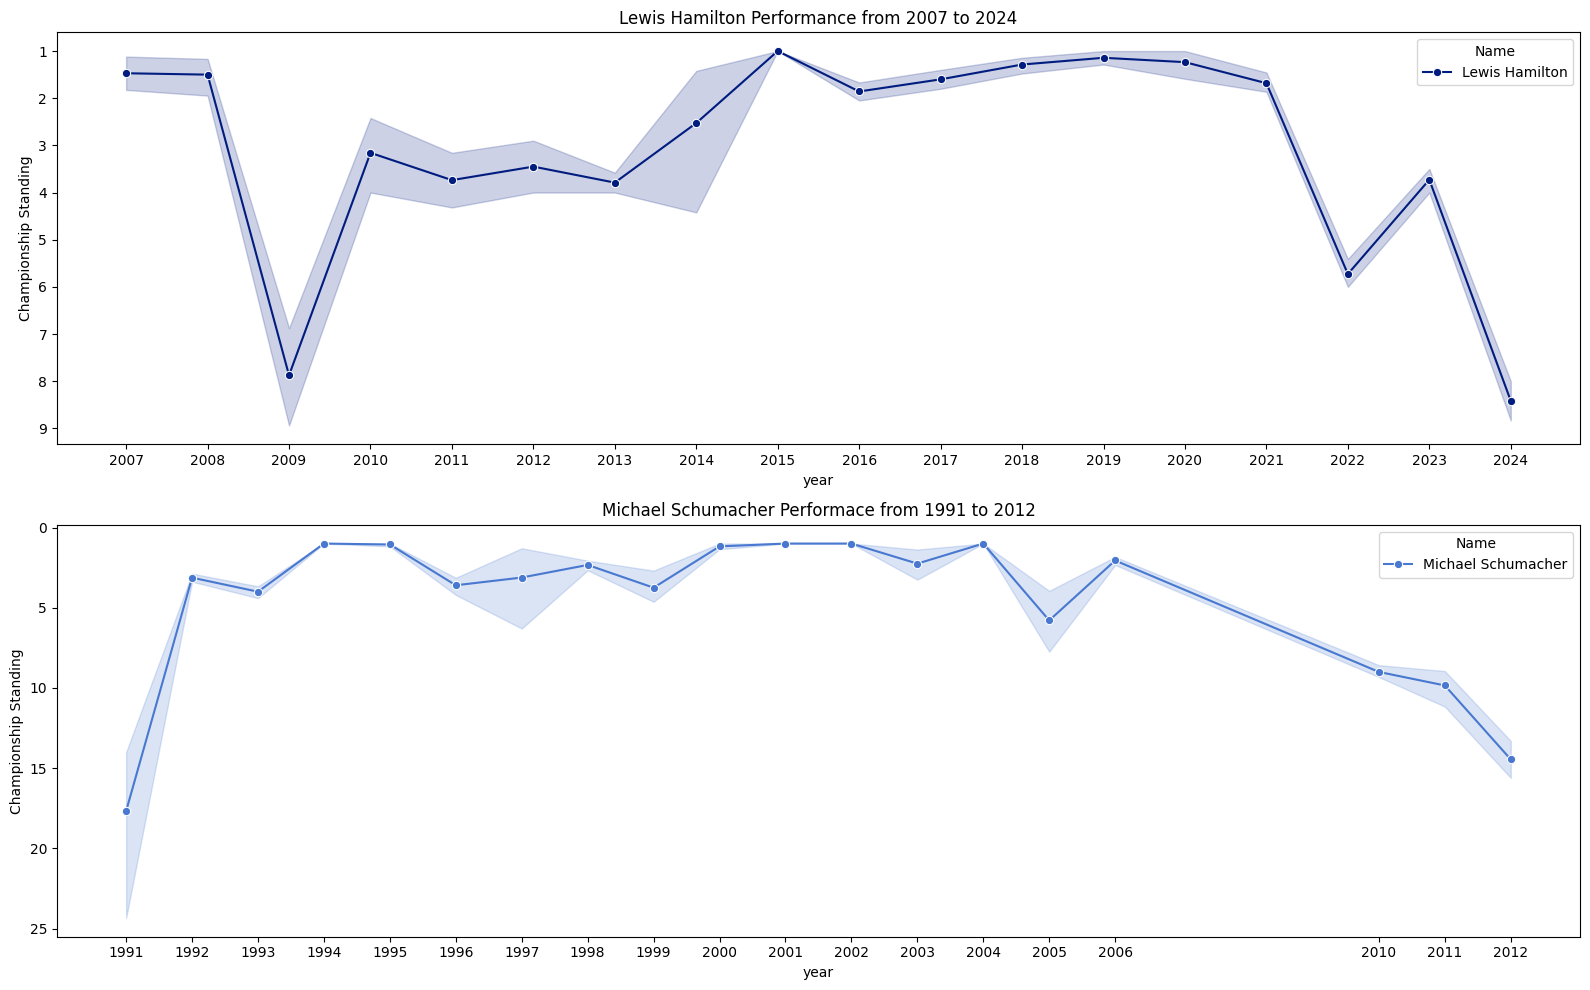

In [46]:
fig , (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,10), sharex = False, sharey = False)
ax1 = sns.lineplot(data= lewis_performance , x = 'year', y= 'position', marker='o',\
                hue= 'Name', palette= 'dark', ax= ax1)
ax1.invert_yaxis()
ax1.set_xticks(lewis_performance['year'].unique())
ax1.set_title('Lewis Hamilton Performance from 2007 to 2024')
ax1.set_ylabel('Championship Standing')

ax2 = sns.lineplot(data= schumacher_performance, x= 'year', y= 'position', marker= 'o',\
                   hue= 'Name', palette= 'muted', ax=ax2)
ax2.invert_yaxis()
ax2.set_xticks(schumacher_performance['year'].unique())
ax2.set_title('Michael Schumacher Performace from 1991 to 2012')
ax2.set_ylabel('Championship Standing')

plt.tight_layout()
plt.show()

#### **Constructor Performance: Ferrari vs. Mercedes**
- A comparative analysis of Ferrari's and Mercedes' constructor performance during the peak years of their lead drivers, Michael Schumacher (Ferrari) and Lewis Hamilton (Mercedes), highlighting their dominance and contributions to their teams' success.

In [47]:
query = """
SELECT *
FROM constructors as c
JOIN constructor_standings as cs
ON c.constructorId = cs.constructorId
JOIN races as r
ON r.raceId = cs.raceId
"""
constructor_df = pd.read_sql(query, engine)

In [48]:
mercedes_performance = constructor_df[(constructor_df['name']== 'Mercedes') & (constructor_df['year'] >=2014) & (constructor_df['year'] <=2024)]

In [49]:
ferrari_performance = constructor_df[(constructor_df['name']== 'Ferrari') & (constructor_df['year'] >=1996) & (constructor_df['year'] <=2006)]

In [50]:
#comparison of constructor
mercedes_ferrari_df = pd.concat([mercedes_performance, ferrari_performance])

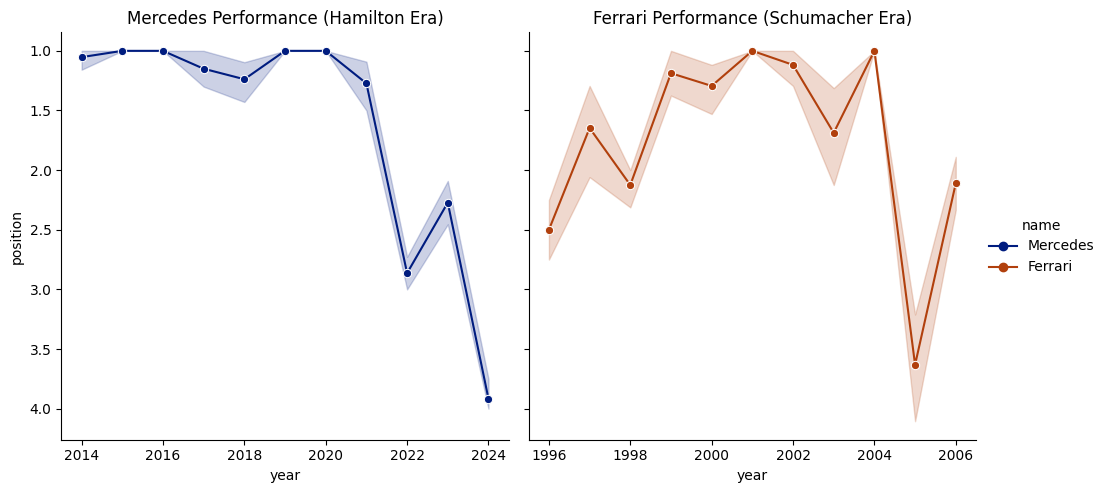

In [51]:
g = sns.relplot(data= mercedes_ferrari_df, x = 'year', y= 'position', col= 'name', kind= 'line', facet_kws= {'sharex': False}, height= 5, aspect=1, marker='o',\
                hue= 'name', palette= 'dark')
plt.gca().invert_yaxis()
titles = ["Mercedes Performance (Hamilton Era)", "Ferrari Performance (Schumacher Era)"]
for ax,title in zip(g.axes.flatten(), titles):
    ax.set_title(title)

#### **Lewis Hamilton Average Lap Pace across his carrer**
- **Objective:**  Analyze Lewis Hamilton's performance by calculating his average lap pace over the course of his career and visualizing the trends using a line plot.

In [52]:
lewis_performance.to_sql('lewis_hamilton', engine, index= False, if_exists= 'replace')

344

In [53]:
query ="""   
SELECT hs.driverId, hs.Name, hs.year, AVG(r.fastestLapSpeed) AS Avg_pace
FROM lewis_hamilton AS hs
JOIN results AS r
ON hs.driverId = r.driverId
AND hs.raceId = r.raceId
GROUP BY hs.driverId, hs.Name, hs.year
"""
hamilton_avg_pace = pd.read_sql(query, engine)
hamilton_avg_pace

,driverId,Name,year,Avg_pace
0,1,Lewis Hamilton,2007,207.627941
1,1,Lewis Hamilton,2008,204.564667
2,1,Lewis Hamilton,2009,200.652080
3,1,Lewis Hamilton,2010,200.365120
4,1,Lewis Hamilton,2011,198.009053
5,1,Lewis Hamilton,2012,197.348264
6,1,Lewis Hamilton,2013,199.885684
7,1,Lewis Hamilton,2014,196.486158
8,1,Lewis Hamilton,2015,200.058632
9,1,Lewis Hamilton,2016,202.202918


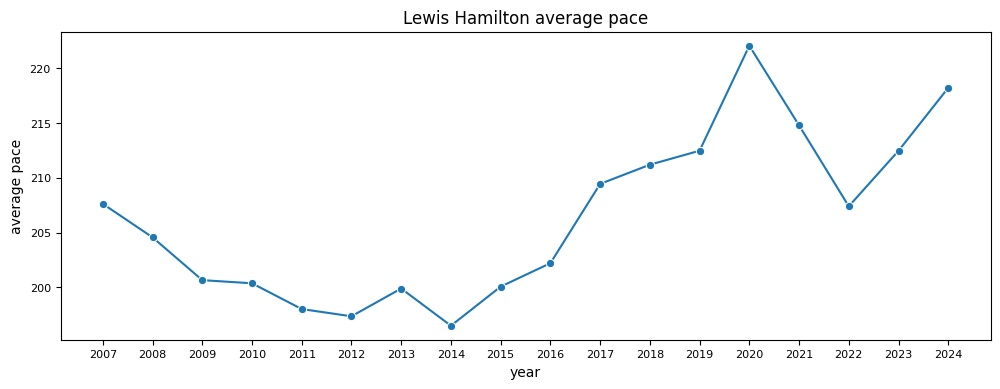

In [54]:
plt.figure(figsize= (12,4))
sns.lineplot(data= hamilton_avg_pace, x= 'year', y= 'Avg_pace', marker= 'o')
plt.xticks(hamilton_avg_pace['year'].unique(), fontsize = 8)
plt.yticks(fontsize= 8)
plt.xlabel('year')
plt.title('Lewis Hamilton average pace')
plt.ylabel('average pace')
plt.show()

#### **Qualifying**

In [55]:
qualifying['q2'] = qualifying['q2'].replace('\\N', 0)
qualifying['q3'] = qualifying['q3'].replace('\\N', 0)

In [56]:
qualifying['Q1'] = qualifying['q1'].apply(time_to_milliseconds)
qualifying['Q2'] = qualifying['q2'].apply(time_to_milliseconds)
qualifying['Q3'] = qualifying['q3'].apply(time_to_milliseconds)

In [57]:
qualifying.drop(columns= ['q1', 'q2', 'q3'], axis=1, inplace= True )

In [ ]:
qualifying['Q2'] = qualifying['Q2'].replace(np.nan, 0)
qualifying['Q3'] = qualifying['Q3'].replace(np.nan, 0)

In [67]:
qualifying.head()

,qualifyId,raceId,driverId,constructorId,number,position,Q1,Q2,Q3
0,1,18,1,1,22,1,86572.0,85187.0,86714.0
1,2,18,9,2,4,2,86103.0,85315.0,86869.0
2,3,18,5,1,23,3,85664.0,85452.0,87079.0
3,4,18,13,6,2,4,85994.0,85691.0,87178.0
4,5,18,2,2,3,5,85960.0,85518.0,87236.0


In [72]:
qualifying.to_sql('qualifying', engine, index = False, if_exists= 'replace')

10254

In [98]:
query = """ 
SELECT d.driverId, d.Name,  
COUNT(CASE WHEN Q1!=0 THEN Q1 END) AS Q1, 
COUNT(CASE WHEN Q2!=0 THEN Q2 END) AS Q2, 
COUNT(CASE WHEN Q3!=0 THEN Q3 END) AS Q3
FROM qualifying AS q
JOIN drivers AS d
ON d.driverId = q.driverId
WHERE q.driverId = 1 
GROUP BY d.driverId, d.Name
"""
hamilton_qualifying_count = pd.read_sql(query, engine)

In [99]:
hamilton_qualifying_count

,driverId,Name,Q1,Q2,Q3
0,1,Lewis Hamilton,341,330,314


In [100]:
hamilton_qualifying_count = pd.melt(frame= hamilton_qualifying_count, id_vars= 'Name', value_vars= ['Q1','Q2','Q3'], var_name= "Qualifying", value_name= 'Count')

In [101]:
hamilton_qualifying_count

,Name,Qualifying,Count
0,Lewis Hamilton,Q1,341
1,Lewis Hamilton,Q2,330
2,Lewis Hamilton,Q3,314


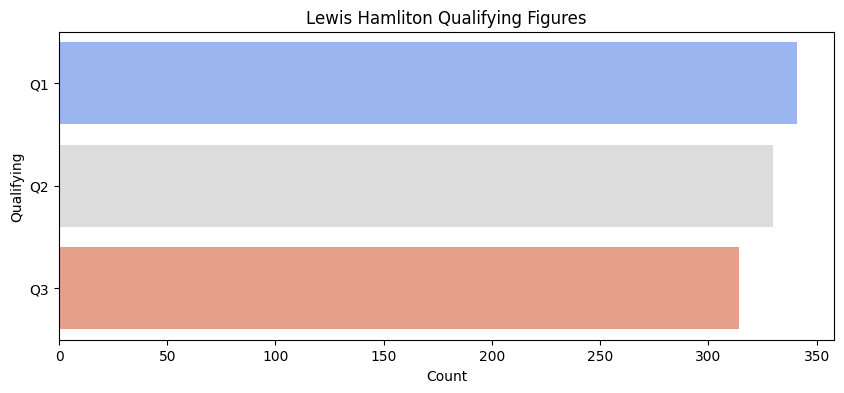

In [103]:
plt.figure(figsize = (10,4))
g= sns.barplot(data= hamilton_qualifying_count, y= 'Qualifying', x= 'Count', hue = 'Qualifying', palette= 'coolwarm')
plt.title('Lewis Hamliton Qualifying Figures')
plt.show()

#### **Drivers with the Highest Pole Positions Count**
- **Objective:** Calculate the total number of pole positions for every drivers by utilzing results and sprint_results table and plotting the top 10 drivers on a bar plot.


In [114]:
query = """ 
WITH result_q AS(
SELECT d.driverId, d.Name,  r.raceId, COUNT(grid) AS Pole_r
FROM drivers AS d
JOIN results AS rs
ON d.driverId = rs.driverId
JOIN races AS r
ON rs.raceID = r.raceID
WHERE rs.grid = 1
GROUP BY d.driverId, d.Name
),
sprint_q AS(
SELECT d.driverId, d.Name,  r.raceId, COUNT(grid) AS Pole_s
FROM drivers AS d
JOIN sprint_results AS s
ON d.driverId = s.driverId
JOIN races AS r
ON s.raceID = r.raceID
WHERE s.grid = 1
GROUP BY d.driverId, d.Name
)
SELECT rq.driverId, rq.Name, 
       COALESCE(Pole_r, 0) + COALESCE(Pole_s, 0) AS Pole
FROM result_q AS rq
LEFT JOIN sprint_q AS sq ON rq.driverId = sq.driverId
ORDER BY POLE DESC
"""

Pole_positions = pd.read_sql(query, engine)

In [116]:
Pole_positions.head(10)

,driverId,Name,Pole
0,1,Lewis Hamilton,105
1,30,Michael Schumacher,68
2,102,Ayrton Senna,65
3,20,Sebastian Vettel,57
4,830,Max Verstappen,48
5,373,Jim Clark,34
6,117,Alain Prost,33
7,95,Nigel Mansell,32
8,3,Nico Rosberg,30
9,579,Juan Fangio,29


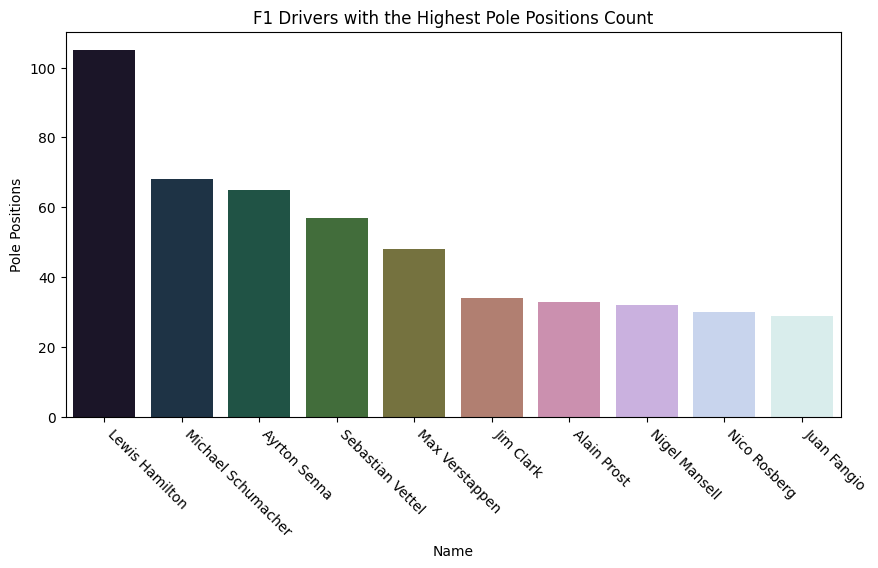

In [137]:
plt.figure(figsize= (10,5))
g = sns.barplot(data= Pole_positions.head(10), x= 'Name', y= 'Pole', hue= 'Name', palette= 'cubehelix')
plt.title('F1 Drivers with the Highest Pole Positions Count')
plt.xticks(rotation = -45, ha= 'left', va= 'top', fontsize = 10)
plt.ylabel('Pole Positions')
plt.show()

#### Pole conversion to race win analysis for Hamilton at silverstone

In [224]:
query= """ 
SELECT DISTINCT r.raceId, r.circuitId, r.Grand_prix, rs.grid, rs.driverId, d.Name, rs.position, r.year
FROM results as rs
JOIN drivers as d
ON d.driverId = rs.driverId
JOIN races as r
ON r.raceId = rs.raceId
JOIN circuits as c
ON c.circuitId = r.circuitId
WHERE c.circuitId = 9 AND d.driverId = 1
GROUP BY r.raceId, r.circuitId, rs.driverId, r.year
"""

hamilton_silverstone = pd.read_sql(query, engine)

In [226]:
hamilton_silverstone = hamilton_silverstone[hamilton_silverstone['Grand_Prix']!='70th Anniversary Grand Prix']

In [227]:
hamilton_silverstone.loc[:, 'position'] = hamilton_silverstone['position'].astype(int)

In [228]:
hamilton_silverstone= pd.melt(frame= hamilton_silverstone, id_vars= 'year', value_vars= ['grid','position'], var_name= 'Position type', value_name= 'Position')

In [229]:
hamilton_silverstone

,year,Position type,Position
0,2009,grid,18
1,2008,grid,4
2,2007,grid,1
3,2010,grid,4
4,2011,grid,10
5,2012,grid,8
6,2013,grid,1
7,2014,grid,6
8,2015,grid,1
9,2016,grid,1


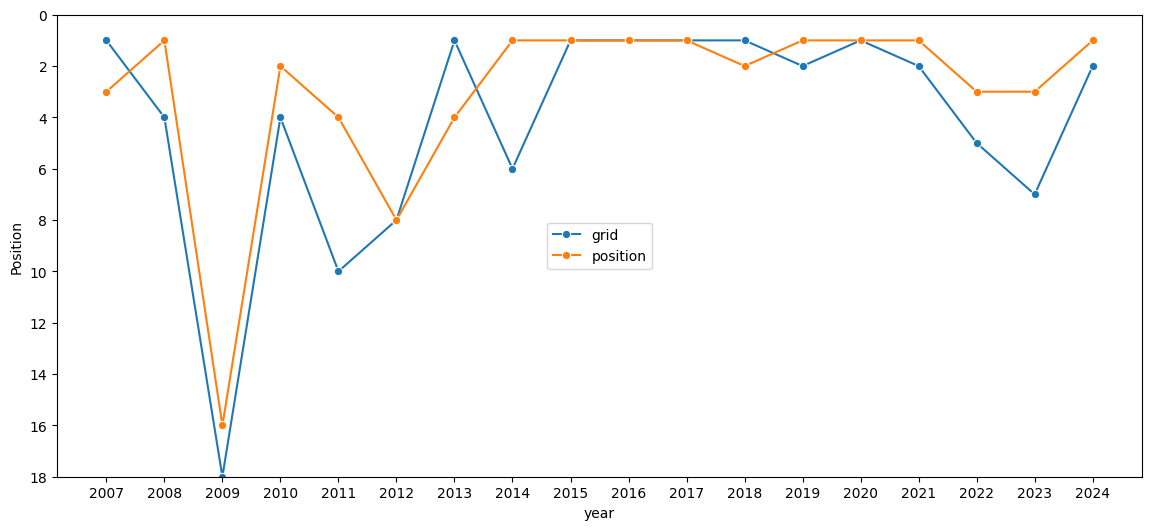

In [223]:
plt.figure(figsize = (14,6))
g= sns.lineplot(data= hamilton_silverstone, x= 'year', y= 'Position', marker = 'o', hue= 'Position type')
plt.ylim(0,18)
plt.gca().invert_yaxis()
plt.xticks(hamilton_silverstone['year'].unique())
plt.legend(loc = 'center')
plt.show()